In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import json

#### Utils

In [58]:
## Global Params
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 18  # Adjust the font size
colors = ['#a8ddb5', '#7bccc4', '#43a2ca','#0868ac']
## Global Params


def read_text_files(directory,component,number,label):
    text_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as file:
                d={
                'In-Flight':0,
                'Throughput':0,
                'Latency(ms)': 0,
                'ScaleFactor': component,
                "# of Components":number,
                "Label":label
                }
                for line in file:
                    if line.startswith("In-Flight Requests"):
                        inFlight = int(line.split(' ')[2].strip())
                        d['In-Flight']=inFlight
                    if line.startswith("Ops/s"):
                        parts = line.split(',')
                        throughput = int(parts[1])
                        d['Throughput']=throughput/30
                    
                    if line.startswith("Average Latency"):
                        latency = int(line.split(' ')[2])
                        d['Latency(ms)']=latency
                
                text_data.append(d)
    return text_data



def read_json_files_to_df(directory,label):
    throughput_data = []
    experiment_number = 1
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                throughput = data.get('Goodput (requests/second)', None)
                latency = data.get('Latency Distribution', None).get('Average Latency (microseconds)',None)
                if latency is not None:
                    latency = latency/1000
                if throughput is not None and latency is not None:
                    throughput_data.append({'Experiment': f'Experiment {experiment_number}', 'Throughput': throughput, "Latency(ms)":latency, "Label":label})
                    experiment_number += 1
    return pd.DataFrame(throughput_data)

## Baseline

### Insecure

Scaling Benchmark --> Drawing Randomly from Possible Range

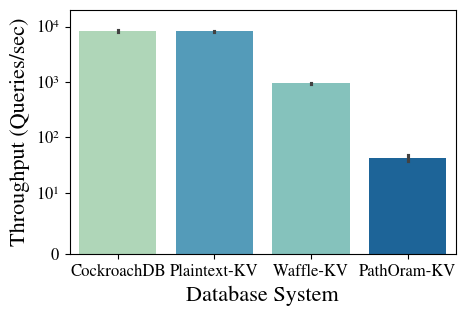

In [59]:
#Read CockroachDB
directory = "/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/Baseline/CockroachDB"
mySQLDF = read_json_files_to_df(directory,"CockroachDB")


#Read Waffle Encrypt Baseline
baselineScaleOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/Baseline/WaffleOne'

#Read Oram Encrypt Baseline
oramScaleOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/Baselines/Scale1'

#Read Plaintext baseline
plaintextDefault = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/Baseline/Plaintext/default'

## Read and Make into DF
readORAMBaseLine = read_text_files(oramScaleOne, '1', 3, "PathOram-KV")
readWaffleBaseLine = read_text_files(baselineScaleOne, '1', 3, "Waffle-KV")
readPTBaseLine = read_text_files(plaintextDefault, '1', 3, "Plaintext-KV")

baseLinePTDF = pd.DataFrame(readPTBaseLine)
baseLineWaffleDF = pd.DataFrame(readWaffleBaseLine)
baseLineORAMDF = pd.DataFrame(readORAMBaseLine)

#Make DF
newDf = pd.concat([mySQLDF,baseLineWaffleDF,baseLinePTDF,baseLineORAMDF])
## Read and Make into DF

#Plotting

displayOrder = ['CockroachDB',"Plaintext-KV","Waffle-KV","PathOram-KV"]
fig, ax = plt.subplots(figsize=(5, 3.5)) 

# Create bar plot
ax = sns.barplot(data=newDf, x='Label', y='Throughput',hue='Label',legend=False, palette=colors, order=displayOrder)

# Labels and title
ax.set_xlabel("Database System", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_yscale("symlog", linthresh=10) 
ax.set_ylim(top=20000)

ax.tick_params(axis='both', which='major', labelsize=12)


fig = ax.get_figure()
fig.tight_layout()
fig.savefig("./figures/plaintextBaselineLog.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [60]:
average_metrics = newDf.groupby('Label').agg({'Latency(ms)': 'mean', 'Throughput': 'mean'}).reset_index()
print(average_metrics)

          Label  Latency(ms)   Throughput
0   CockroachDB   137.999000  8425.470509
1   PathOram-KV   832.333333    41.722222
2  Plaintext-KV   118.000000  8247.233333
3     Waffle-KV   931.666667   946.444444


### Secure Baseline

BDB Benchmark --> Drawing randomly from list of possible values in benchmark

/tmp/ipykernel_3243275/1028572663.py:25: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(data=combined_df, x='Label', y='Throughput',hue='Label',legend=False, palette=colors, order=displayOrder)


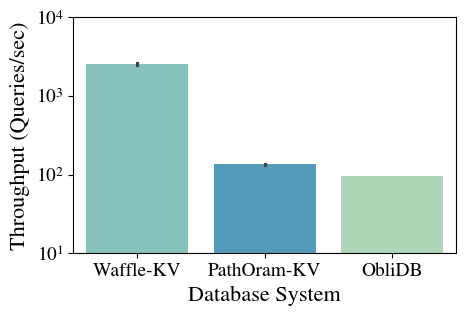

In [61]:
## ObliDB Records for BDB

obliDB = pd.read_csv('/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/Baseline/ObliDB/ObliDBStats.csv')
obliDB['Label'] = 'ObliDB'
obliDB['Latency(ms)'] = obliDB['AvgLatency(s)'] * 1000

# Waffle Baseline for BDB
waffleBaselineBLOOM = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/Baseline/BDBRanking'
readWaffleBaseLine = pd.DataFrame(read_text_files(waffleBaselineBLOOM, '1', 3, "Waffle-KV"))

#Oram Baseline for BDB
ORAMBaselineBLOOM = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/Baselines/BDB_rankings_table'
readORAMBaseLine = pd.DataFrame(read_text_files(ORAMBaselineBLOOM, '1', 3, "PathOram-KV"))

# Combine the dataframes
combined_df = pd.concat([obliDB[['Label', 'Throughput','Latency(ms)']], readWaffleBaseLine[['Label', 'Throughput','Latency(ms)']], readORAMBaseLine[['Label', 'Throughput','Latency(ms)']]])

# Reset index for the combined dataframe
combined_df.reset_index(drop=True, inplace=True)

combined_df
displayOrder = ['Waffle-KV',"PathOram-KV","ObliDB"]

fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed
ax = sns.barplot(data=combined_df, x='Label', y='Throughput',hue='Label',legend=False, palette=colors, order=displayOrder)

ax.set_xlabel("Database System", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_yscale("log")
ax.set_yscale("symlog")  # Adjust linthresh to control the transition point
ax.set_ylim(10, 10000)

# ax.set_title("Comparison: ObliDB, ObliSQL(Waffle) and ObliSQL(ORAM)", fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=14)
# plt.show()

fig = ax.get_figure()
fig.tight_layout()
fig.savefig("./figures/obliviousBaselineLog.pdf")



In [62]:
average_metrics = combined_df.groupby('Label').agg({'Latency(ms)': 'mean', 'Throughput': 'mean'}).reset_index()
average_metrics

,Label,Latency(ms),Throughput
0,ObliDB,10.336667,96.753333
1,PathOram-KV,362.666667,135.000000
2,Waffle-KV,380.333333,2591.433333


## Scaling

#### Scaling to 5

Scaling Benchmark --> Drawing Randomly from Possible Range

/tmp/ipykernel_3243275/3910814761.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=proxyDF, x='Machines', y='Throughput', err_style='bars', err_kws={'ecolor': 'black'}, palette=colors, linewidth=2)


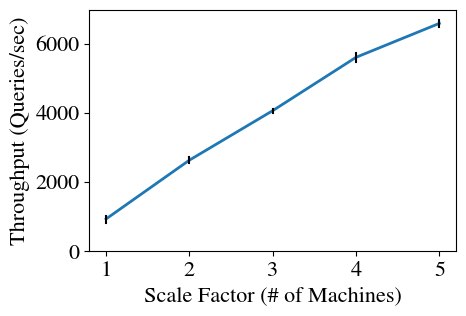

In [63]:

scaleOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/ScalingTo5/Scale1' 
scaleTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/ScalingTo5/Scale2'
ScaleThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/ScalingTo5/Scale3' 
ScaleFour = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/ScalingTo5/Scale4'
ScaleFive = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/ScalingTo5/Scale5'


readScaleOne = read_text_files(scaleOne, '1', 3, "10ms-Latency")
readScaleTwo = read_text_files(scaleTwo, '2', 3, "10ms-Latency")
readScaleThree = read_text_files(ScaleThree, '3', 3, "10ms-Latency")
readScaleFour = read_text_files(ScaleFour, '4', 3, "10ms-Latency")
readScaleFive = read_text_files(ScaleFive, '5', 3, "10ms-Latency")

oneDF = pd.DataFrame(readScaleOne)
twoDF = pd.DataFrame(readScaleTwo)
threeDF = pd.DataFrame(readScaleThree)
fourDF = pd.DataFrame(readScaleFour)
fiveDF = pd.DataFrame(readScaleFive)


proxyDF = pd.concat([
    oneDF, twoDF, threeDF, fourDF,fiveDF])


proxyDF.rename(columns={'ScaleFactor': 'Machines','Label':"Latency"}, inplace=True)



fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed


sns.lineplot(data=proxyDF, x='Machines', y='Throughput', err_style='bars', err_kws={'ecolor': 'black'}, palette=colors, linewidth=2)


ax.set_xlabel("Scale Factor (# of Machines)",fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)
# ax.set_title("Comparison: ObliDB, ObliSQL(Waffle) and ObliSQL(ORAM)",fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.show()

fig = ax.get_figure()
fig.tight_layout()
fig.savefig("./figures/horizontalScalingLinear.pdf")



### ORAM

/tmp/ipykernel_3243275/1160859715.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=proxyDF, x='Machines', y='Throughput', err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,linewidth=2)


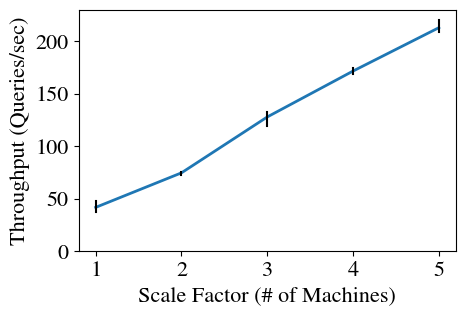

In [64]:

scaleOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/ScalingTo5/Scale1' 
scaleTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/ScalingTo5/Scale2'
ScaleThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/ScalingTo5/Scale3' 
ScaleFour = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/ScalingTo5/Scale4'
ScaleFive = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/ScalingTo5/Scale5'


readScaleOne = read_text_files(scaleOne, '1', 3, "10ms-Latency")
readScaleTwo = read_text_files(scaleTwo, '2', 3, "10ms-Latency")
readScaleThree = read_text_files(ScaleThree, '3', 3, "10ms-Latency")
readScaleFour = read_text_files(ScaleFour, '4', 3, "10ms-Latency")
readScaleFive = read_text_files(ScaleFive, '5', 3, "10ms-Latency")

oneDF = pd.DataFrame(readScaleOne)
twoDF = pd.DataFrame(readScaleTwo)
threeDF = pd.DataFrame(readScaleThree)
fourDF = pd.DataFrame(readScaleFour)
fiveDF = pd.DataFrame(readScaleFive)


proxyDF = pd.concat([
    oneDF, twoDF, threeDF, fourDF,fiveDF])

proxyDF.rename(columns={'ScaleFactor': 'Machines','Label':"Latency"}, inplace=True)


fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed

sns.lineplot(data=proxyDF, x='Machines', y='Throughput', err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,linewidth=2)


ax.set_xlabel("Scale Factor (# of Machines)",fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)
# ax.set_title("Comparison: ObliDB, ObliSQL(Waffle) and ObliSQL(ORAM)",fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.show()

fig = ax.get_figure()
fig.tight_layout()
# fig.tight_layout()
fig.savefig("./figures/ORAMhorizontalScalingLog.pdf")

# proxyDF 
# Keeep more empty requests. (Draw from random distribution of range of ids). 

#### Per Layer Scaling (Waffle)

/tmp/ipykernel_3243275/3234622569.py:59: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.lineplot(data=proxyDF, x='ScaleFactor', y='Throughput', hue='Label',


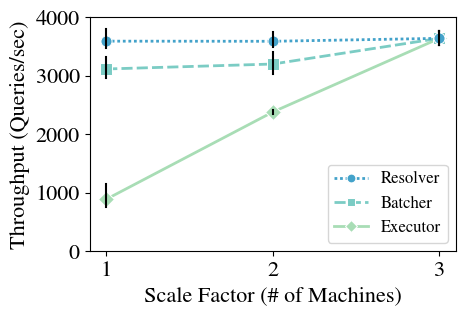

In [65]:
# Inflight - 3000 -->Waffle

#resolver

resolverScalingOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Resolver/1_3_3'
resolverScalingTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Resolver/2_3_3'
resolverScalingThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Resolver/3_3_3'

oneResolver = read_text_files(resolverScalingOne,'1',3,"Resolver")
twoResolver = read_text_files(resolverScalingTwo,'2',3,"Resolver")
threeResolver = read_text_files(resolverScalingThree,'3',3,"Resolver")

oneResolverDF = pd.DataFrame(oneResolver)
twoResolverDF = pd.DataFrame(twoResolver)
threeResolverDF = pd.DataFrame(threeResolver)

resolverDF = pd.concat([oneResolverDF, twoResolverDF, threeResolverDF])


#Batcher
BatcherScalingOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Batcher/3_1_3'
BatcherScalingTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Batcher/3_2_3'
BatcherScalingThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Batcher/3_3_3'

oneBatcher = read_text_files(BatcherScalingOne,'1',3,"Batcher")
twoBatcher = read_text_files(BatcherScalingTwo,'2',3,"Batcher")
threeBatcher = read_text_files(BatcherScalingThree,'3',3,"Batcher")

oneBatcherDF = pd.DataFrame(oneBatcher)
twoBatcherDF = pd.DataFrame(twoBatcher)
threeBatcherDF = pd.DataFrame(threeBatcher)

batcherDF = pd.concat([oneBatcherDF, twoBatcherDF, threeBatcherDF])

#Proxy

ProxyScalingOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Proxy/3_3_1'
ProxyScalingTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Proxy/3_3_2'
ProxyScalingThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/PerLayerScaling/Proxy/3_3_3'

oneProxy = read_text_files(ProxyScalingOne,'1',3,"Executor")
twoProxy = read_text_files(ProxyScalingTwo,'2',3,"Executor")
threeProxy = read_text_files(ProxyScalingThree,'3',3,"Executor")

oneProxyDF = pd.DataFrame(oneProxy)
twoProxyDF = pd.DataFrame(twoProxy)
threeProxyDF = pd.DataFrame(threeProxy)

proxyDF = pd.concat([oneProxyDF, twoProxyDF, threeProxyDF,oneBatcherDF,twoBatcherDF,threeBatcherDF,oneResolverDF,twoResolverDF,threeResolverDF])
# data = proxyDF.groupby(['ScaleFactor','Label'])['Throughput'].mean().reset_index()


fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed

# Define marker styles for each category
marker_styles = {'Resolver': 'o', 'Batcher': 's', 'Executor': 'D'}  

# Create line plot with markers
ax = sns.lineplot(data=proxyDF, x='ScaleFactor', y='Throughput', hue='Label',
                  err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,
                  style='Label', markers=marker_styles, markersize=8,linewidth=2)

# Set labels
ax.set_xlabel("Scale Factor (# of Machines)", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_ylim(0, 4000)
# Reduce tick label size
ax.tick_params(axis='both', which='major', labelsize=16)

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
desired_order = ['Resolver', 'Batcher', 'Executor']  # Your preferred order
ordered_handles = [handles[labels.index(label)] for label in desired_order]
ordered_labels = [label for label in desired_order]
ax.legend(ordered_handles, ordered_labels, fontsize=12, markerscale=0.8)

# Adjust layout
fig.tight_layout()
plt.show()
fig.savefig("./figures/perLayerScalingLinear.pdf")

In [66]:
average_metrics = proxyDF.groupby(['Label','ScaleFactor']).agg({'Latency(ms)': 'mean', 'Throughput': 'mean'}).reset_index()
average_metrics

,Label,ScaleFactor,Latency(ms),Throughput
0,Batcher,1,927.666667,3117.022222
1,Batcher,2,913.000000,3201.900000
2,Batcher,3,805.333333,3641.588889
3,Executor,1,3366.333333,887.022222
4,Executor,2,1225.333333,2380.722222
5,Executor,3,805.333333,3641.588889
6,Resolver,1,819.666667,3593.400000
7,Resolver,2,817.666667,3591.133333
8,Resolver,3,805.333333,3641.588889


### Per Layer Scaling (ORAM)

/tmp/ipykernel_3243275/1505768432.py:57: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.lineplot(data=proxyDF, x='ScaleFactor', y='Throughput', hue='Label',


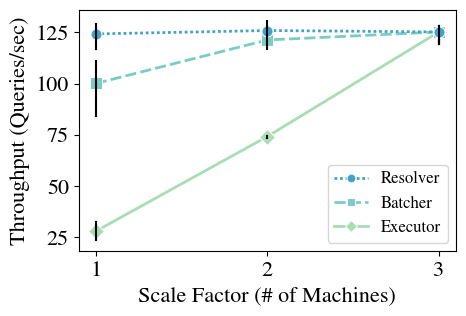

In [67]:
# Inflight - 100 -->ORAM

#resolver

resolverScalingOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Resolver/1_3_3'
resolverScalingTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Resolver/2_3_3'
resolverScalingThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Resolver/3_3_3'

oneResolver = read_text_files(resolverScalingOne,'1',3,"Resolver")
twoResolver = read_text_files(resolverScalingTwo,'2',3,"Resolver")
threeResolver = read_text_files(resolverScalingThree,'3',3,"Resolver")

oneResolverDF = pd.DataFrame(oneResolver)
twoResolverDF = pd.DataFrame(twoResolver)
threeResolverDF = pd.DataFrame(threeResolver)

resolverDF = pd.concat([oneResolverDF, twoResolverDF, threeResolverDF])


#Batcher
BatcherScalingOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Batcher/3_1_3'
BatcherScalingTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Batcher/3_2_3'
BatcherScalingThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Batcher/3_3_3'

oneBatcher = read_text_files(BatcherScalingOne,'1',3,"Batcher")
twoBatcher = read_text_files(BatcherScalingTwo,'2',3,"Batcher")
threeBatcher = read_text_files(BatcherScalingThree,'3',3,"Batcher")

oneBatcherDF = pd.DataFrame(oneBatcher)
twoBatcherDF = pd.DataFrame(twoBatcher)
threeBatcherDF = pd.DataFrame(threeBatcher)

batcherDF = pd.concat([oneBatcherDF, twoBatcherDF, threeBatcherDF])

#Proxy

ProxyScalingOne = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Proxy/3_3_1'
ProxyScalingTwo = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Proxy/3_3_2'
ProxyScalingThree = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/PerLayer/Proxy/3_3_3'

oneProxy = read_text_files(ProxyScalingOne,'1',3,"Executor")
twoProxy = read_text_files(ProxyScalingTwo,'2',3,"Executor")
threeProxy = read_text_files(ProxyScalingThree,'3',3,"Executor")

oneProxyDF = pd.DataFrame(oneProxy)
twoProxyDF = pd.DataFrame(twoProxy)
threeProxyDF = pd.DataFrame(threeProxy)

proxyDF = pd.concat([oneProxyDF, twoProxyDF, threeProxyDF,oneBatcherDF,twoBatcherDF,threeBatcherDF,oneResolverDF,twoResolverDF,threeResolverDF])

fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed

# Define marker styles for each category
marker_styles = {'Resolver': 'o', 'Batcher': 's', 'Executor': 'D'}  

# Create line plot with markers
ax = sns.lineplot(data=proxyDF, x='ScaleFactor', y='Throughput', hue='Label',
                  err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,
                  style='Label', markers=marker_styles, markersize=8,linewidth=2)

# Set labels
ax.set_xlabel("Scale Factor (# of Machines)", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)

# Reduce tick label size
ax.tick_params(axis='both', which='major', labelsize=16)

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
desired_order = ['Resolver', 'Batcher', 'Executor']  # Your preferred order
ordered_handles = [handles[labels.index(label)] for label in desired_order]
ordered_labels = [label for label in desired_order]
ax.legend(ordered_handles, ordered_labels, fontsize=12, markerscale=0.8)

# Adjust layout
fig.tight_layout()
plt.show()
fig.savefig("./figures/ORAMperLayerScalingLinear.pdf")

In [68]:
average_metrics = proxyDF.groupby(['Label','ScaleFactor']).agg({'Latency(ms)': 'mean', 'Throughput': 'mean'}).reset_index()
average_metrics


,Label,ScaleFactor,Latency(ms),Throughput
0,Batcher,1,992.000000,100.044444
1,Batcher,2,804.333333,121.233333
2,Batcher,3,784.333333,125.155556
3,Executor,1,3429.666667,28.033333
4,Executor,2,1313.333333,74.188889
5,Executor,3,784.333333,125.155556
6,Resolver,1,791.333333,124.177778
7,Resolver,2,782.000000,125.844444
8,Resolver,3,784.333333,125.155556


## Microbenchmarks

#### Join Bloom (Waffle)

Scaling Benchmark --> Drawing Randomly from possible pairs (Reads File). So no empty requests

/tmp/ipykernel_3243275/3757317767.py:17: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(data=combinedDF, x='Label', y='Throughput',hue='Label',legend=False, palette=colors,order=order)


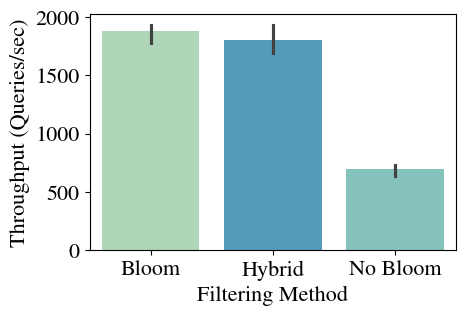

In [69]:
completeBloomNew = "/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/JoinBloom/Bloom"
completeDefaultNew = "/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/JoinBloom/Default"
completeHybridNew = "/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/JoinBloom/Hybrid"


completeBloomNewDF = pd.DataFrame(read_text_files(completeBloomNew, "3", "3", "Bloom"))
completeDefaultNewDF = pd.DataFrame(read_text_files(completeDefaultNew, "3", "3", "No Bloom"))
completeHybridNewDF = pd.DataFrame(read_text_files(completeHybridNew, "3", "3", "Hybrid"))

combinedDF = pd.concat([completeBloomNewDF,completeDefaultNewDF,completeHybridNewDF])
# combinedDF = combinedDF.groupby(["Label"])['Throughput'].mean().reset_index()
combinedDF
order = ['Bloom', 'Hybrid', 'No Bloom']


fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed
ax = sns.barplot(data=combinedDF, x='Label', y='Throughput',hue='Label',legend=False, palette=colors,order=order)

ax.set_xlabel("Filtering Method",fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)
# ax.set_title("Comparison: ObliDB, ObliSQL(Waffle) and ObliSQL(ORAM)",fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.show()

fig = ax.get_figure()
fig.tight_layout()
fig.savefig("./figures/joinBloomLinear.pdf")



### Join Bloom (ORAM)

/tmp/ipykernel_3243275/2691946399.py:17: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(data=combinedDF, x='Label', y='Throughput',hue='Label',legend=False, palette=colors,order=order)


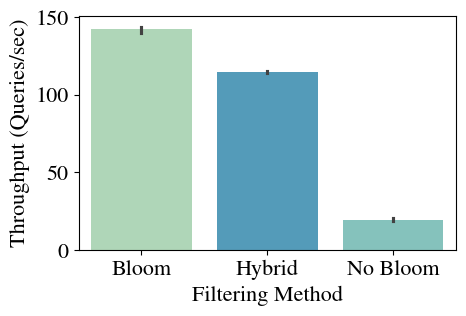

In [70]:
completeBloomNew = "/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/JoinBloom/Bloom"
completeDefaultNew = "/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/JoinBloom/Default"
completeHybridNew = "/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/JoinBloom/Hybrid"


completeBloomNewDF = pd.DataFrame(read_text_files(completeBloomNew, "3", "3", "Bloom"))
completeDefaultNewDF = pd.DataFrame(read_text_files(completeDefaultNew, "3", "3", "No Bloom"))
completeHybridNewDF = pd.DataFrame(read_text_files(completeHybridNew, "3", "3", "Hybrid"))

combinedDF = pd.concat([completeBloomNewDF,completeDefaultNewDF,completeHybridNewDF])
# combinedDF = combinedDF.groupby(["Label"])['Throughput'].mean().reset_index()
combinedDF
order = ['Bloom', 'Hybrid', 'No Bloom']


fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed
ax = sns.barplot(data=combinedDF, x='Label', y='Throughput',hue='Label',legend=False, palette=colors,order=order)

ax.set_xlabel("Filtering Method",fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)
# ax.set_title("Comparison: ObliDB, ObliSQL(Waffle) and ObliSQL(ORAM)",fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.show()

fig = ax.get_figure()
fig.tight_layout()
fig.savefig("./figures/joinBloomOram.pdf")



In [71]:
combinedDF

,In-Flight,Throughput,Latency(ms),ScaleFactor,# of Components,Label
0,100,139.966667,704,3,3,Bloom
1,100,143.800000,679,3,3,Bloom
2,100,142.900000,691,3,3,Bloom
0,100,19.733333,4741,3,3,No Bloom
1,100,18.766667,4977,3,3,No Bloom
2,100,20.466667,4537,3,3,No Bloom
0,100,115.266667,847,3,3,Hybrid
1,100,114.100000,862,3,3,Hybrid
2,100,114.533333,857,3,3,Hybrid


In [72]:

data = {
    'Total Keys': [311472,311732,285123,
                   427416,413860,457824,
                   1320152,1320742,1119386],

    'Total Requests': [75859,75923,69272,
                       69225,66970,74296,
                       28782,28801,24088],
    'Type': ["Bloom","Bloom","Bloom","Hybrid","Hybrid","Hybrid","No Bloom","No Bloom","No Bloom"]
}
df_keys_requests = pd.DataFrame(data)
df_keys_requests['Req/S'] = df_keys_requests['Total Keys']/df_keys_requests['Total Requests']
avgReqs = df_keys_requests.groupby(["Type"])['Req/S'].mean().reset_index()
avgReqs

,Type,Req/S
0,Bloom,4.109274
1,Hybrid,6.172082
2,No Bloom,46.065158


#### Range Bloom (Waffle)

Scaling Benchmark --> Drawing Randomly from possible range (Extended for int range)

/tmp/ipykernel_3243275/1513454686.py:40: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.lineplot(data=proxyDF, x='Selectivity', y='Throughput', hue='Filter',


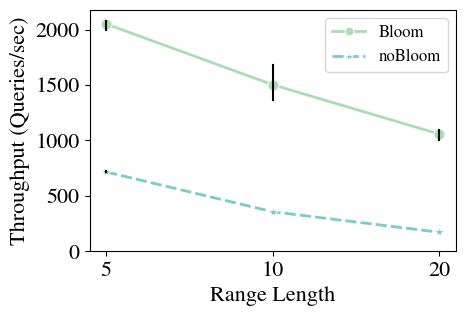

In [73]:
selectivity5Bloom  = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/RangeBloom/DefaultRange/Selectivity5/Bloom'
selectivity5NoBloom  = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/RangeBloom/DefaultRange/Selectivity5/Default'

selectivity10Bloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/RangeBloom/DefaultRange/Selectivity10/Bloom'
selectivity10NoBloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/RangeBloom/DefaultRange/Selectivity10/Default'

selectivity20Bloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/RangeBloom/DefaultRange/Selectivity20/Bloom'
selectivity20NoBloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/WaffleData/RangeBloom/DefaultRange/Selectivity20/Default'

selectivity5BloomData = read_text_files(selectivity5Bloom, '5', 3, "Bloom")
selectivity5NoBloomData = read_text_files(selectivity5NoBloom, '5', 3, "noBloom")

selectivity10BloomData = read_text_files(selectivity10Bloom, '10', 3, "Bloom")
selectivity10NoBloomData = read_text_files(selectivity10NoBloom, '10', 3, "noBloom")

selectivity20BloomData = read_text_files(selectivity20Bloom, '20', 3, "Bloom")
selectivity20NoBloomData = read_text_files(selectivity20NoBloom, '20', 3, "noBloom")

selectivity5BloomDF = pd.DataFrame(selectivity5BloomData)
selectivity5NoBloomDF = pd.DataFrame(selectivity5NoBloomData)
selectivity10BloomDF = pd.DataFrame(selectivity10BloomData)
selectivity10NoBloomDF = pd.DataFrame(selectivity10NoBloomData)
selectivity20BloomDF = pd.DataFrame(selectivity20BloomData)
selectivity20NoBloomDF = pd.DataFrame(selectivity20NoBloomData)

proxyDF = pd.concat([selectivity5BloomDF, selectivity5NoBloomDF, selectivity10BloomDF, selectivity10NoBloomDF, selectivity20BloomDF, selectivity20NoBloomDF])
proxyDF.rename(columns={'ScaleFactor': 'Selectivity', 'Label':"Filter"}, inplace=True)

# Assuming proxyDF is your DataFrame
order=["5","10","20"]
proxyDF['Selectivity'] = pd.Categorical(proxyDF['Selectivity'], categories=order, ordered=True)
proxyDF = proxyDF.sort_values('Selectivity')

fig, ax = plt.subplots(figsize=(5, 3.5))

# Define marker styles for each category
marker_styles = {'Bloom': 'o', 'noBloom': '*'}  # 'o' for circles, 's' for squares

# Main lineplot with markers and error bars
ax = sns.lineplot(data=proxyDF, x='Selectivity', y='Throughput', hue='Filter', 
                  err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,
                  style='Filter', markers=marker_styles, markersize=8,linewidth=2)

ax.set_xlabel("Range Length", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=16)

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
desired_order = ['Bloom', 'noBloom']  # Your preferred order
ordered_handles = [handles[labels.index(label)] for label in desired_order]
ordered_labels = [label for label in desired_order]
ax.legend(ordered_handles, ordered_labels, fontsize=12, markerscale=0.8)

fig.tight_layout()
fig.savefig("./figures/rangeBloomLinear.pdf")

#Times new Roman Font in the graph
# Add Title 
# Fix Axis labels.


### Measure How many keys are we returning per non-empty request in this experiment will help us justify why tpx/s is reducing as we increase selectivity.

### Range(ORAM)

/tmp/ipykernel_3243275/1905720061.py:48: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.lineplot(data=proxyDF, x='Selectivity', y='Throughput', hue='Filter',


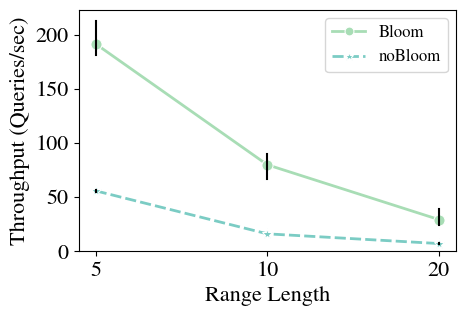

In [74]:
selectivity5Bloom  = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/RangeBloom/DefaultRange/Selectivity5/Bloom'
selectivity5NoBloom  = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/RangeBloom/DefaultRange/Selectivity5/NoBloom'

selectivity10Bloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/RangeBloom/DefaultRange/Selectivity10/Bloom'
selectivity10NoBloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/RangeBloom/DefaultRange/Selectivity10/NoBloom'

selectivity20Bloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/RangeBloom/DefaultRange/Selectivity20/Bloom'
selectivity20NoBloom = '/home/haseeb/Desktop/Plotting/OverleafGraphs/OramData/RangeBloom/DefaultRange/Selectivity20/NoBloom'

selectivity5BloomData = read_text_files(selectivity5Bloom, '5', 3, "Bloom")
selectivity5NoBloomData = read_text_files(selectivity5NoBloom, '5', 3, "noBloom")

selectivity10BloomData = read_text_files(selectivity10Bloom, '10', 3, "Bloom")
selectivity10NoBloomData = read_text_files(selectivity10NoBloom, '10', 3, "noBloom")

selectivity20BloomData = read_text_files(selectivity20Bloom, '20', 3, "Bloom")
selectivity20NoBloomData = read_text_files(selectivity20NoBloom, '20', 3, "noBloom")

selectivity5BloomDF = pd.DataFrame(selectivity5BloomData)
selectivity5NoBloomDF = pd.DataFrame(selectivity5NoBloomData)
selectivity10BloomDF = pd.DataFrame(selectivity10BloomData)
selectivity10NoBloomDF = pd.DataFrame(selectivity10NoBloomData)
selectivity20BloomDF = pd.DataFrame(selectivity20BloomData)
selectivity20NoBloomDF = pd.DataFrame(selectivity20NoBloomData)

proxyDF = pd.concat([selectivity5BloomDF, selectivity5NoBloomDF, selectivity10BloomDF, selectivity10NoBloomDF, selectivity20BloomDF, selectivity20NoBloomDF])
proxyDF.rename(columns={'ScaleFactor': 'Selectivity', 'Label':"Filter"}, inplace=True)
# proxyDF = proxyDF.groupby(["Filter","Selectivity"])['Throughput'].mean().reset_index()


# ax = sns.lineplot(data=proxyDF, x='Selectivity', y='Throughput', hue='Filter')
# ax.set_xlabel("Selectivity (Range Size)")
# # proxyDF

# Assuming proxyDF is your DataFrame
order=["5","10","20"]
proxyDF['Selectivity'] = pd.Categorical(proxyDF['Selectivity'], categories=order, ordered=True)
proxyDF = proxyDF.sort_values('Selectivity')

marker_styles = {'Bloom': 'o', 'noBloom': 's'}  # 'o' for circles, 's' for squares

fig, ax = plt.subplots(figsize=(5, 3.5))

# Define marker styles for each category
marker_styles = {'Bloom': 'o', 'noBloom': '*'}  # 'o' for circles, 's' for squares

# Main lineplot with markers and error bars
ax = sns.lineplot(data=proxyDF, x='Selectivity', y='Throughput', hue='Filter', 
                  err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,
                  style='Filter', markers=marker_styles, markersize=8,linewidth=2)

ax.set_xlabel("Range Length", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=16)

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
desired_order = ['Bloom', 'noBloom']  # Your preferred order
ordered_handles = [handles[labels.index(label)] for label in desired_order]
ordered_labels = [label for label in desired_order]
ax.legend(ordered_handles, ordered_labels, fontsize=12, markerscale=0.8)

fig.tight_layout()
fig.savefig("./figures/ORAMrangeBloomLinear.pdf")
plt.show()

#Times new Roman Font in the graph
# Add Title 
# Fix Axis labels.


### Measure How many keys are we returning per non-empty request in this experiment will help us justify why tpx/s is reducing as we increase selectivity.